# Spectral vs Segmentation? A comparison of two different approaches to classifying lawn area
https://github.com/robbieheumann/Turfgrass2024

## Random forest classification
- I want to train two machine learning algorithms to classify satellite imagery pixels that are turf grass
  
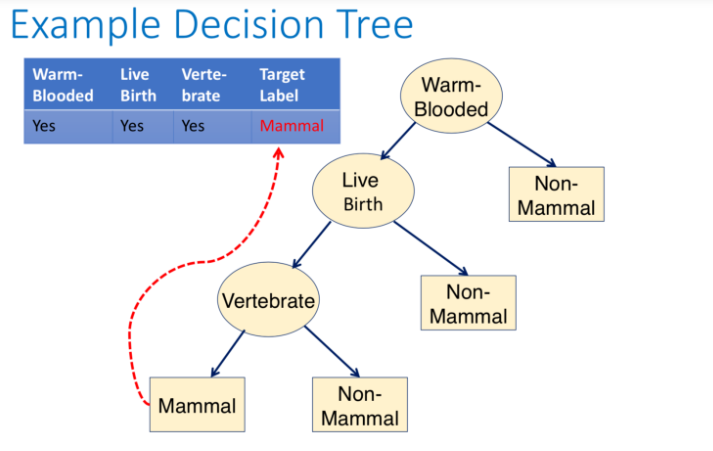

- One model will be trained on an segmented image using sci-kit segementation tools
- The other model will be trained on rgbn spectral data
  
- I want to then compare the accuracy of the two models internally and externally 

# First steps
## 1. Prepare training dataset

In [1]:
from osgeo import gdal
from matplotlib import pyplot
import numpy as np
import scipy as sp
from skimage.segmentation import quickshift
from matplotlib import colors
from scipy import stats
ds = gdal.Open(r'C:\Users\rh176228\Desktop\Programming GIS\final\data\missoula_aoi_03_2024.tif', gdal.GA_ReadOnly)
geo_transform = ds.GetGeoTransform()
proj = ds.GetProjectionRef()
bands = ds.RasterCount 
print('Bands =',  bands, 
      "           Projection =", proj, 
      "           Geo Transform =", geo_transform) 

Bands = 5            Projection = PROJCS["NAD83 / UTM zone 12N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26912"]]            Geo Transform = (271495.9702, 0.6000000000000173, 0.0, 5194695.6, 0.0, -0.5999999999998327)


C:\OSGeo4W\apps\Python39\lib\site-packages\osgeo\gdal.py:315: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [2]:
data = ds.ReadAsArray()
data.shape

(5, 3339, 2698)

In [3]:
band_data2 = data[0:4, :, :]
band_data3 = np.rollaxis(band_data2, 0, 3)
band_data3.shape

(3339, 2698, 4)

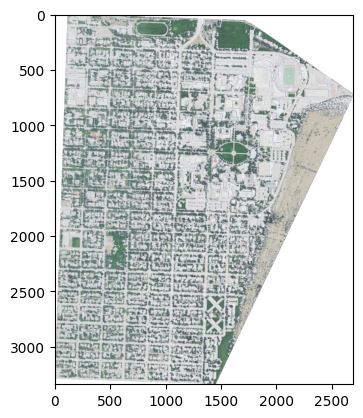

In [4]:
pyplot.imshow(band_data3[:, :, 0:4])

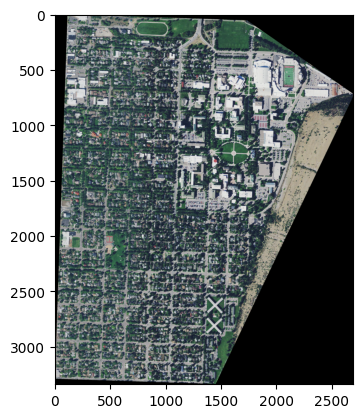

In [5]:
rgb_img = band_data3[:, :, 0:3]
grass = band_data3[:, :, 0:3]
pyplot.imshow(rgb_img)

In [6]:
grass.shape

(3339, 2698, 3)

In [7]:
train1 = band_data3[200:500, 500:1000, :]
train2 = band_data3[2500:2800, 1200:1700, :]
train3 = band_data3[1100:1400, 1300:1800, :]

Text(0.5, 1.0, 'training dataset 3')

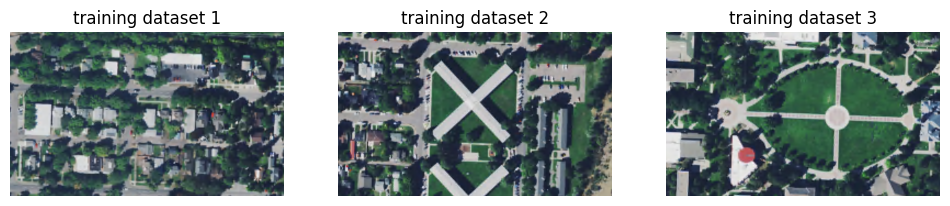

In [8]:
fig, axes = pyplot.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(train1[:, :, 0:3])
axes[0].axis('off')
axes[0].set_title('training dataset 1')
axes[1].imshow(train2[:, :, 0:3])
axes[1].axis('off')
axes[1].set_title('training dataset 2')
axes[2].imshow(train3[:, :, 0:3])
axes[2].axis('off')
axes[2].set_title('training dataset 3')


## Extract known lawn pixels and impervious surface pixels to prepare training data
- combine them into one dataset
- train the random forest model on the combined dataset using just RGB band values as predictors of lawn.  

In [9]:
train = np.concatenate([train1, train2, train3], axis=1)

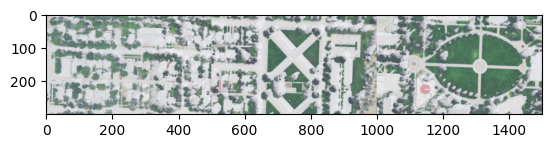

In [10]:
pyplot.imshow(train)

In [11]:
## extract known lawn pixels
## first identify lawn areas with NDVI so I can use a single value to index pixels with lawn

In [12]:
train_ndvi = ((train[:, :, 3]) - (train[:, :, 0]) / (train[:, :, 3] + train[:, :, 0]))
train_ndvi.shape

C:\Users\rh176228\AppData\Local\Temp\ipykernel_11904\4032593818.py:1: RuntimeWarning: divide by zero encountered in divide
  train_ndvi = ((train[:, :, 3]) - (train[:, :, 0]) / (train[:, :, 3] + train[:, :, 0]))


(300, 1500)

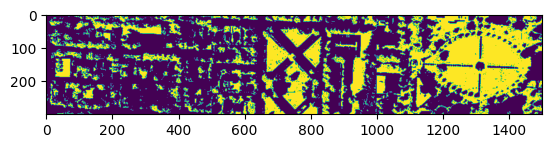

In [13]:
pyplot.imshow(train_ndvi>=190)

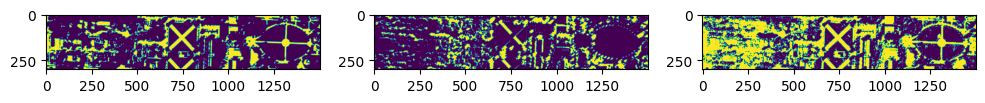

In [14]:
#pyplot.imshow(train_ndvi>=210)
fig, axes = pyplot.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(train[:, :, 0] > 130)
axes[1].imshow(train[:, :, 1] <= 50)
axes[2].imshow(train[:, :, 2] >= 75)

In [15]:
### imperv pixels and tree pixels
imperv_pixels = train[:, :, 0] > 130
tree_pixels = np.ma.masked_where(train_ndvi > 190, train_ndvi)

In [16]:
imperv_train = imperv_pixels.reshape(-1, imperv_pixels.shape[-1])
imperv_train.shape

(300, 1500)

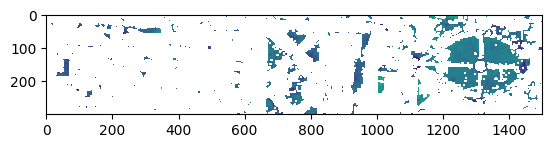

In [17]:
training_grass = np.ma.masked_where(train_ndvi < 190, train_ndvi)
pyplot.imshow(training_grass)

In [18]:
grass_indices = np.where(training_grass > 190)

# Zip the indices to get the pixel coordinates
pixel_coordinates = list(zip(grass_indices[0], grass_indices[1]))

In [19]:
# Initialize an empty array to store the extracted pixels
extracted_pixels = np.zeros_like(train)

# Loop through each pixel coordinate and extract the corresponding pixel value
for coord in pixel_coordinates:
    row, col = coord
    extracted_pixels[row, col] = train[row, col]

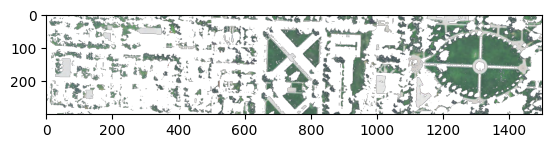

In [20]:
pyplot.imshow(extracted_pixels)

In [21]:
extracted_pixels.shape

(300, 1500, 4)

In [22]:
np.argwhere(np.isnan(extracted_pixels))

array([], shape=(0, 3), dtype=int64)

## Extracting individual band data

In [23]:
red_grass = extracted_pixels[:, :, 0] > 0
green_grass = extracted_pixels[:, :, 1] > 0
blue_grass = extracted_pixels[:, :, 2] > 0
nir_grass = extracted_pixels[:, :, 3] > 0
nir_grass.shape

(300, 1500)

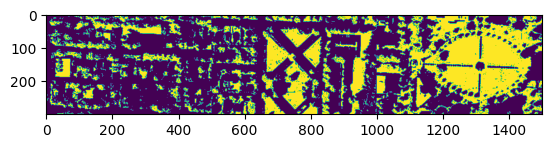

In [24]:
grass = np.any(extracted_pixels > 0, axis=2).astype(int)
pyplot.imshow(grass)

In [25]:
grass.shape

(300, 1500)

## Fit random forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(min_samples_leaf = 2, max_features = 'sqrt')
model.fit(red_grass + green_grass+ blue_grass+ nir_grass, grass)

RandomForestClassifier(min_samples_leaf=2)

## Assess model accuracy

In [27]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(train[:,:,0]+train[:,:,1]+train[:,:,2]+train[:,:,3])
mean_squared_error(grass, predictions, squared = False) # We want RMSE, not MSE, so squared = False

C:\OSGeo4W\apps\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.5560329254705686

## Segmentation Classifier

In [28]:
train.shape

(300, 1500, 4)

In [29]:
grass_segs = quickshift(train, kernel_size=4, max_dist=4, ratio=0.75, convert2lab=False)
n_segments = len(np.unique(grass_segs))
print(n_segments)

1598


In [30]:
from matplotlib import colors
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))

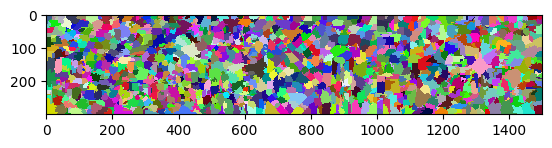

In [31]:
pyplot.imshow(grass_segs, interpolation='none', cmap=cmap)

In [32]:
grass_segs.shape

(300, 1500)

In [33]:
segments_extract_grass = np.zeros_like(grass_segs)

# Loop through each pixel coordinate and extract the corresponding pixel value
for coord in pixel_coordinates:
    row, col = coord
    segments_extract_grass[row, col] = grass_segs[row, col]

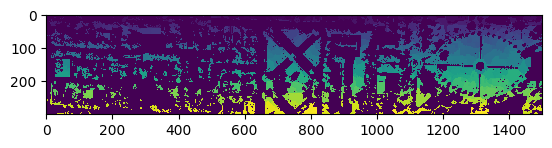

In [34]:
pyplot.imshow(segments_extract_grass, interpolation='none')

In [35]:
grass_segments = (segments_extract_grass > 10).astype(int)
grass_segments.shape


(300, 1500)

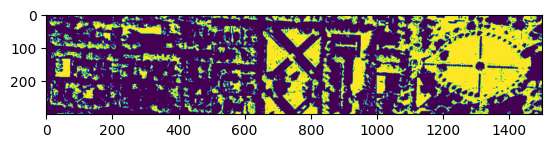

In [36]:
pyplot.imshow(grass_segments)

In [37]:
lawn_mod = model.fit(grass_segs, grass_segments)

In [38]:
predictions_segs = model.predict(grass_segs)
mean_squared_error(grass_segments, predictions_segs, squared = False)

C:\OSGeo4W\apps\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.1369268682575961

In [39]:
grass_segs.shape

(300, 1500)

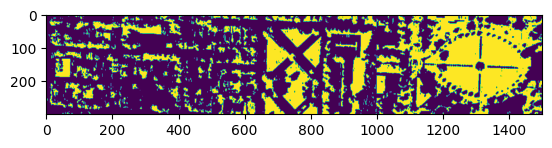

In [40]:
pyplot.imshow(predictions_segs)

In [41]:
np.sum(predictions_segs == grass)/(300*1500)


0.9771933333333334

In [42]:
grass.shape

(300, 1500)

## FULL EXTERNAL TEST TBD


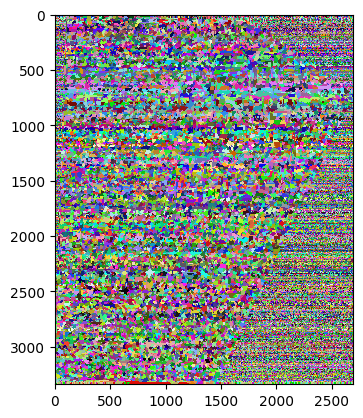

In [43]:
full_grass_segs = quickshift(rgb_img, kernel_size=4, max_dist=4, ratio=0.75, convert2lab=False)
n_segments_2 = len(np.unique(full_grass_segs))
cmap2 = colors.ListedColormap(np.random.rand(n_segments_2, 3))
pyplot.imshow(full_grass_segs, interpolation='none', cmap=cmap)

lawn_mod.predict(full_grass_segs)

full_grass_segs.shape

from sklearn.ensemble import RandomForestClassifier

help(RandomForestClassifier)

classifier = RandomForestRegressor(n_jobs=-1)
classifier.fit(red_grass + green_grass+ blue_grass+ nir_grass, grass)

from sklearn import metrics

predicted_class = classifier.predict(train[:,:,0]+train[:,:,1]+train[:,:,2]+train[:,:,3])
print("Classification accuracy: %f" %
      metrics.accuracy_score(grass, predicted_class))